Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 125, 128) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 125, 65) - (classes+ensaios, canais, janelas, linhas)
SVM:  (0.12666666666666668,)
SVM Normalizado:  0.5533333333333333


/home/isabela/topicos/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 0s 1ms/step
Acurácia: 73.22%
Matriz de confusão:
[[98  2  0  3  0  1  0  9]
 [ 1 97  2  3  0  4  0  6]
 [ 3  2 81  8  5  4  3  7]
 [ 1 10  3 60 27  9  1  2]
 [ 0  0  0  7 93  1  0 11]
 [ 4  2  2  4  9 77  8  6]
 [ 0  3  5 14 19  4 61  6]
 [ 1  6  2  0  9  0  2 92]]

              precision    recall  f1-score   support

           0    0.90741   0.86726   0.88688       113
           1    0.79508   0.85841   0.82553       113
           2    0.85263   0.71681   0.77885       113
           3    0.60606   0.53097   0.56604       113
           4    0.57407   0.83036   0.67883       112
           5    0.77000   0.68750   0.72642       112
           6    0.81333   0.54464   0.65241       112
           7    0.66187   0.82143   0.73307       112

    accuracy                        0.73222       900
   macro avg    0.74756   0.73217   0.73100       900
weighted avg    0.74775   0.73222   0.73115       900



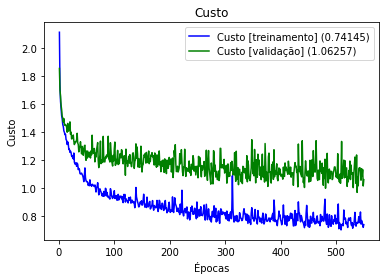

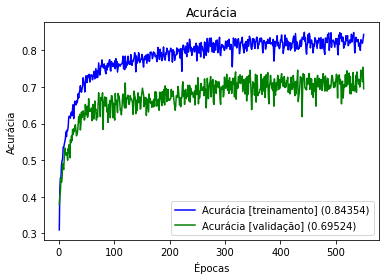

In [3]:
### Bibliotecas

import pandas as pd
import numpy as np
from scipy import signal
from math import prod
from scipy.signal import stft
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
from math import e
from glob import glob
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


### Filtragem

def butter_bandpass(data, lowcut, highcut, fs = 200, order = 4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype = 'bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs = 200, order = 4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype = 'lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs = 200, order = 4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype = 'highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var = 1, fs = 200, order = 4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype = 'bandstop', ftype = "butter")
    return signal.filtfilt(b, a, data)


### Carrega Arquivos

data = []
def CarregaSujeito(diretorio):
    data = np.load("datasets/topicos_cc/" + diretorio)
    data = np.transpose(data, (0, 2, 1))
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    
    return data_filtered

diretorio = [ i.split("/")[-1] for i in glob('datasets/topicos_cc/s10*')]

for a in diretorio:
    data.append(CarregaSujeito(a))
    

### Concatenação dos Movimentos

X = np.concatenate((data), axis = 0)
X.shape


### Segmentação de Dados (janelamento)

data = X
step = 11.8
segment = 128
# data = X.reshape(24, 4, 1600)
# print('', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * int(step)

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=128, noverlap=115)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')


### Extração de Características

def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def f_j(j, SampleRate, M):
    return (j * SampleRate) / (2 * M)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def WL(x):
    return np.sum(np.abs(np.diff(x)), axis = -1)

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def WAMP(x, limiar):
    return np.sum( np.abs(np.diff(x)) > limiar, axis= -1)

def WL(x):
    return np.sum(np.abs(np.diff(x)), axis = -1)

def ZC_Add(data, th):
    
    somatorio = 0
    resultado = 0
    tamanho = len(data)
    
    for i in range(tamanho - 1):
        resultado1 = (data[i] * data[i+1])
        resultado2 = np.abs((data[i] - data[i+1]))
        
        if(resultado1 < 0) and (resultado2 >=  th):
            somatorio += 1
    return somatorio

def ZC(data, th):
    
    x,y,z = data.shape[:3]
    somatorio_final = []
    for i in range(x):
        somatorio_fx = []
        for j in range(y):
            somatorio_fy = []
            for k in range(z):
                somatorio_fz = ZC_Add(data[i][j][k], th)
                
                somatorio_fy.append(somatorio_fz)
            
            somatorio_fx.append(somatorio_fy)
        
        somatorio_final.append(somatorio_fx)
        
    return np.array(somatorio_final)

def f_j(j, SampleRate, M):
    return (j * SampleRate) / (2 * M)

def FMN_Add(data):
    M = len(data)
    somatorio = 0
    denominador = np.sum(PSD(data), axis=-1)
    
    for j in range(M):
        somatorio += (f_j(j, 200, M) * PSD(data[j])) / denominador
    return somatorio


def FMN(data):
    x,y,z = data.shape[:3]
    somatorio_final = []
    
    for i in range(x):
        somatorio_fx = []
        for j in range(y):
            somatorio_fy = []
            for k in range(z):
                somatorio_fz = FMN_Add(data[i][j][k])
                
                somatorio_fy.append(somatorio_fz)
            
            somatorio_fx.append(somatorio_fy)
        
        somatorio_final.append(somatorio_fx)
        
    return np.array(somatorio_final)

def A_j(w):
    return np.abs(w)

def MMNF_Add(data):
    
    M = len(data)
    somatorio = 0
    denominador = np.sum(A_j(data), axis=-1)
    
    for j in range(M):
        somatorio += ( f_j(j, 200, M) * A_j(data[j])) / denominador
    return somatorio


def MMNF(data):
   
    x,y,z = data.shape[:3]
    somatorio_final = []
    
    for i in range(x):
        somatorio_fx = []
        for j in range(y):
            somatorio_fy = []
            for k in range(z):
                somatorio_fz = MMNF_Add(data[i][j][k])
                
                somatorio_fy.append(somatorio_fz)
            
            somatorio_fx.append(somatorio_fy)
        
        somatorio_final.append(somatorio_fx)
        
    return np.array(somatorio_final)

PontoMax = np.max(chunks_time)
PontoMax

Mediana = np.median(chunks_time)
Mediana

MeuLimiar = (PontoMax + Mediana) / 2
MeuLimiar

Media = np.mean(chunks_time)
Media

MeuLimiarNovo = (PontoMax + Media) / 2
MeuLimiarNovo


### Novas Extrações de Características

def LogD(data):
    from math import e
    N = np.prod(data.shape)
    
    return e ** ( np.sum(np.log10( np.abs(data) ), axis = -1) ) / N

def IEMG(data):
    # tempo
    return np.sum(A_j(data), axis=-1)

def DASDV(data):
    #tempo
    return np.sqrt( np.sum(np.diff(data) ** 2, axis = -1) / (np.prod(data.shape[:-1]) - 1) )

def TM3(x):
    N = np.prod(x.shape[:-1])
    return np.abs(np.sum(x ** 3, axis = -1) / N)
def TM4(x):
    N = np.prod(x.shape[:-1])
    return np.abs(np.sum(x ** 4, axis = -1) / N)
def TM5(x):
    N = np.prod(x.shape[:-1])
    return np.abs(np.sum(x ** 5, axis = -1) / N)


### Implementação do Vetor

final_data = list()

# Domínio do tempo
final_data.append(WAMP(chunks_time, Mediana))
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(WL(chunks_time))
final_data.append(ZC(chunks_time, 0))

final_data.append(LogD(chunks_time))
final_data.append(IEMG(chunks_time))
final_data.append(DASDV(chunks_time))
final_data.append(TM3(chunks_time))
final_data.append(TM4(chunks_time))
final_data.append(TM5(chunks_time))

#Domínio da frequência
final_data.append(fmd(chunks_freq))
final_data.append(FMN(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(MMNF(chunks_freq))

f, Pxx_den = signal.welch(data, fs=200, nperseg=248, noverlap=223)
final_data.append(Pxx_den)

final = np.array(final_data)
final.shape


### Seleção de Caraterísticas 
## Transpose

# Sinais Recebidos
data = final.transpose(1, 3, 2, 0)
X = data.reshape(data.shape[0] * data.shape[1], data.shape[2] * data.shape[3])
X.shape

# Tipos de Movimentos
y = [ [(i)] * int(X.shape[0] / 8 ) for i in range(8)]
y = np.array(y).flatten()
y.shape


## Normalização

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


### Classificador SVM

def do_svm(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle=True, stratify=y)

    clf = SVC(gamma = 'scale')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    
    return acc

resultado_SVM = do_svm(X, y),
resultado_SVM_norm = do_svm(X_norm, y)

print("SVM: ", resultado_SVM)
print("SVM Normalizado: ", resultado_SVM_norm)

### Redes Neurais
## Bibliotecas Redes Neurais

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from urllib.request import urlopen, urlretrieve
import matplotlib.pyplot as plt

%matplotlib inline


## Função que Plota os Custos e a Acurácia

def plot_history(h):
    loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Custo não está presente no histórico')
        return
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    # Custo
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Custo [treinamento] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Custo [validação] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    plt.title('Custo')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    # Acurácia
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Acurácia [treinamento] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Acurácia [validação] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()
    

## Divisão de Testes e Treinos

# Dividindo em conjuntos de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.3, stratify=y)

# treino: 80% dos 80% de treino. teste: 20% dos 80% de treino.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train)


## Aplicação do MPL e Geração de Resultados

# definição de uma fração do regularizador
l = 0.01

# desenvolvimento do modelo Keras para uma MLP
model = Sequential()
model.add(Dense(20, activation = 'relu', input_dim = 64,
                kernel_regularizer = regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)

model.add(Dense(10, activation = 'relu',
                kernel_regularizer = regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)

model.add(Dense(8, activation = 'softmax'))

# Aplicação de um modelo de descida de gradiente utilizando o Stocastic Gradient Descendent (SGD)

# Função de otimização da rede: ADAM
adam = Adam(lr = 0.005, beta_1 = 0.9, beta_2 = 0.999)
# Função de custo baseada em dados originalmente categóricos
model.compile(loss='sparse_categorical_crossentropy', optimizer = adam,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs = 550, batch_size = 15,
                    validation_data = (X_val, y_val), verbose = 0)


## Plotando Matriz de Confusão

predict_x = model.predict(X_test) 
score = np.argmax(predict_x, axis=1)
y_true = y_test

print('Acurácia: %0.2f%%' % (accuracy_score(y_true, score) * 100))
print('Matriz de confusão:')
print(confusion_matrix(y_true, score))
print()
print(classification_report(y_true, score, digits = 5))


## Plotando os Gráficos de Custo e acurácia

plot_history(history)